In [1]:
!pip install keras==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 21.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [2]:
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)

2024-06-04 15:50:31.483475: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 15:50:31.483573: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 15:50:31.597521: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0
2.15.0


In [3]:
# Importing dependencies

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import *
import keras
from tensorflow.keras.callbacks import Callback

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score,RocCurveDisplay

SEED = 42
IMG_SIZE = 224, 224
BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE

In [4]:
# creating main dataframe contains image paths and their classes.

def create_images_list(path):
    full_path = []
    images = sorted(os.listdir(path))
    for i in images:
        full_path.append(os.path.join(path, i))
    return full_path


classes = {0: 'Benign', 1: 'Malignant'}

train_benign_imgs = create_images_list('/kaggle/input/melanoma-cancer-dataset/train/Benign')
train_malignant_imgs = create_images_list('/kaggle/input/melanoma-cancer-dataset/train/Malignant')

full_data = pd.concat([pd.DataFrame({'image' : train_benign_imgs, 'label': 0 }),
                      pd.DataFrame({'image' : train_malignant_imgs, 'label': 1 })])
# shuffling dataset
full_data = full_data.sample(frac = 1, ignore_index = True, random_state = SEED)

# train and valid splitting
train_data, valid_data = train_test_split(full_data, test_size = 0.2, stratify = full_data['label'])

train_data = train_data.reset_index(drop = True)
valid_data = valid_data.reset_index(drop = True)

# test dataframe
test_benign_imgs = create_images_list('/kaggle/input/melanoma-cancer-dataset/test/Benign')
test_malignant_imgs = create_images_list('/kaggle/input/melanoma-cancer-dataset/test/Malignant')

test_data = pd.concat([pd.DataFrame({'image' : test_benign_imgs, 'label': 0 }),
                       pd.DataFrame({'image' : test_malignant_imgs, 'label': 1 })])
test_data = test_data.sample(frac = 1, ignore_index = True, random_state = SEED)


print('total train images \t{0}'.format(train_data.shape[0]))
print('total valid images \t{0}'.format(valid_data.shape[0]))
print('total test images \t{0}'.format(test_data.shape[0]))

total train images 	9503
total valid images 	2376
total test images 	2000


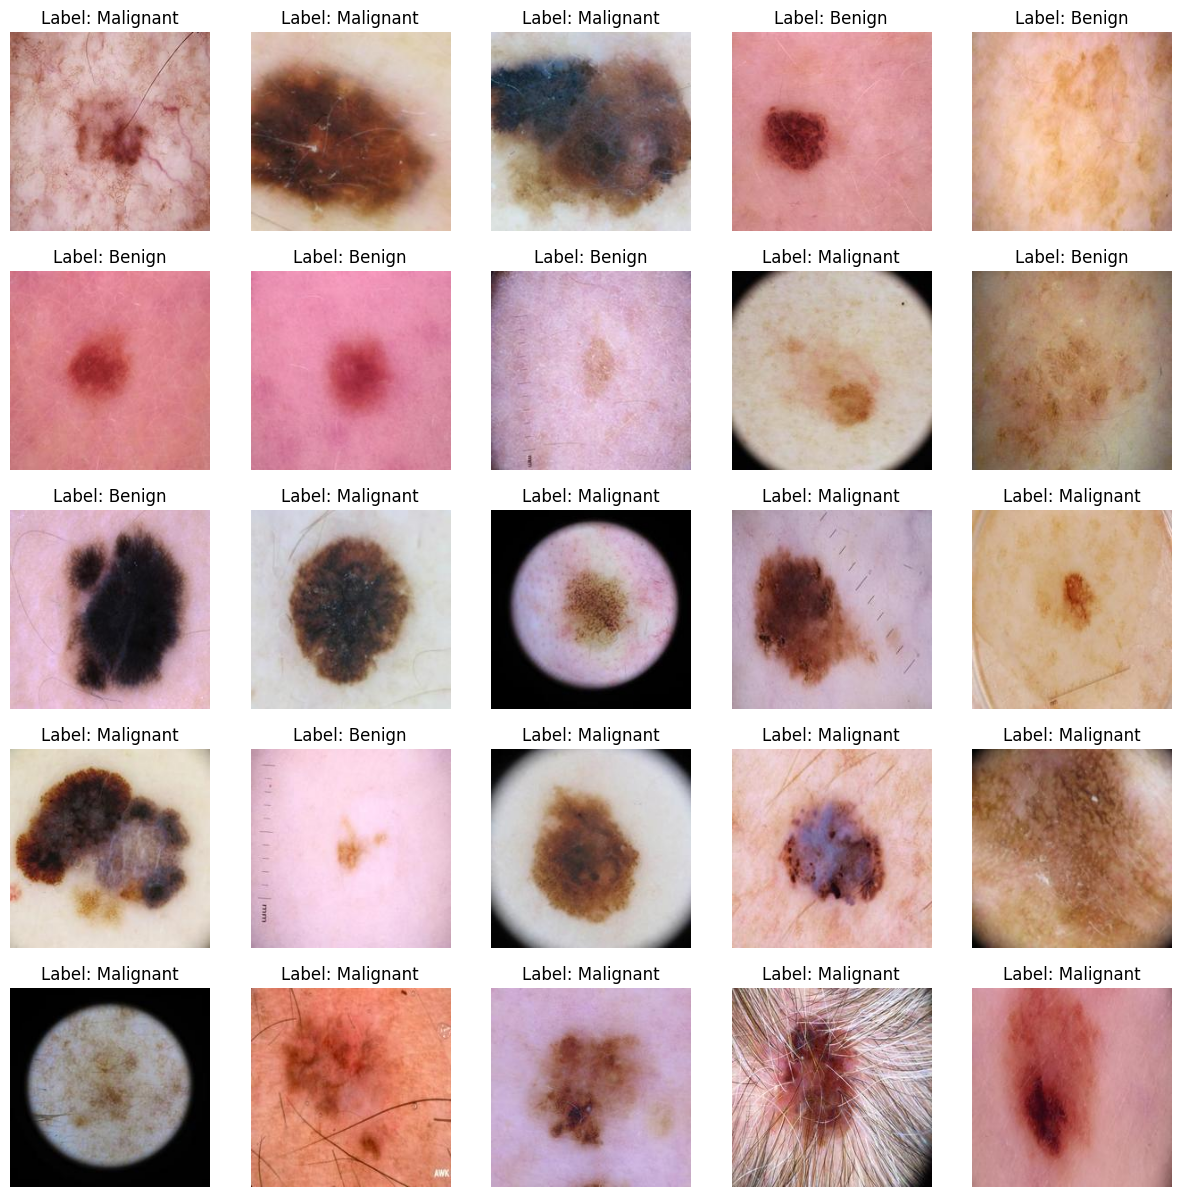

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Print 25 random samples from the training data with inferno colormap
plt.figure(figsize=(15, 15))

for i in range(25):
    ax = plt.subplot(5, 5, i+1)
    random_index = np.random.randint(0, train_data.shape[0])
    img_path = train_data.loc[random_index, 'image']
    img = Image.open(img_path)
    plt.imshow(img)
    ax.set_title(f"Label: {classes[train_data.loc[random_index, 'label']]}")
    ax.axis('off')

plt.show()

In [6]:
# Reading -> Resizing -> Normalization
def img_preprocessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_png(img, channels = 3)
    img = tf.image.resize(img, size =(IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0


    return img, label


# Data augmentation
img_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation((-0.3, 0.3), interpolation="bilinear"),
    RandomContrast(0.03),
    RandomCrop(*IMG_SIZE)])

In [7]:
# Creating dataset loaders and tf.datasets

train_loader = tf.data.Dataset.from_tensor_slices((train_data['image'], train_data['label']))
train_dataset = (train_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .shuffle(BATCH_SIZE*10)
                 .batch(BATCH_SIZE)
                 .map(lambda img, label: (img_augmentation(img), label), num_parallel_calls =AUTO)
                 .prefetch(AUTO))


valid_loader = tf.data.Dataset.from_tensor_slices((valid_data['image'], valid_data['label']))
valid_dataset = (valid_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO))

test_loader = tf.data.Dataset.from_tensor_slices((test_data['image'], test_data['label']))
test_dataset = (test_loader
                 .map(img_preprocessing, num_parallel_calls = AUTO)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO))

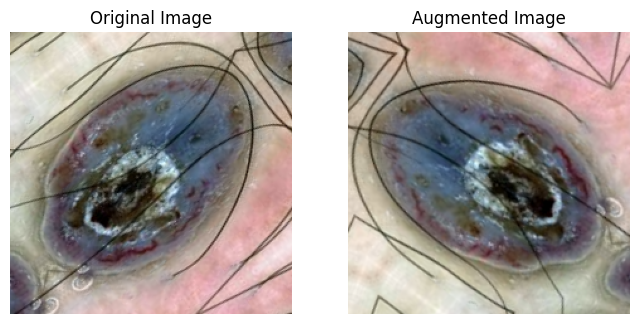

In [8]:
# Display original and augmented image for the first sample
def display_sample_images(dataset):
    for images, labels in dataset.take(1):
        # Display original image
        original_image = images[0].numpy()
        
        # Apply augmentation
        augmented_image = img_augmentation(images[0:1], training=True)[0].numpy()
        
        # Plotting
        plt.figure(figsize=(8, 4))
        
        # Original image
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(original_image,cmap='inferno')
        plt.axis("off")
        
        # Augmented image
        plt.subplot(1, 2, 2)
        plt.title("Augmented Image")
        plt.imshow(augmented_image,cmap='inferno')
        plt.axis("off")
        
        plt.show()
        break

# Display original and augmented images from train dataset
display_sample_images(train_dataset)

In [9]:
# a custom callback for evaluation of test set during training each 10 loop
class Test_Pred_During_Training(Callback):

    def __init__(self, model):
        self.model = model

    def on_epoch_end(self, epochs, logs = None ):
        try:
            if (epochs+1) % 10 == 0:
                test_pred = self.model.predict(test_dataset, verbose = 0)
                test_pred = np.argmax(test_pred, axis = 1)

                mse = mean_squared_error(test_data['label'], test_pred)
                f1 = f1_score(test_data['label'], test_pred, average = 'weighted')
                acc = accuracy_score(test_data['label'], test_pred)

                print('\nMean Squared Error : {0:.5f}'.format(mse))
                print('Weighted F1 Score : {0:.3f}'.format(f1))
                print('Accuracy Score : {0:.3f} %'.format(acc*100))

                print("--"*40)
        except ValueError:
            pass

In [10]:
# !pip install tensorflow-hub

In [11]:
import tensorflow_hub as hub
bit_model_url = "https://www.kaggle.com/models/google/bit/frameworks/TensorFlow2/variations/s-r152x4/versions/1"
bit_module = hub.KerasLayer(bit_model_url)

Attaching model 'google/bit/tensorflow2/s-r152x4/1' to your Kaggle notebook...


In [12]:
from tensorflow import keras
class MyBiTModel(keras.Model):
    def __init__(self, num_classes, module, **kwargs):
        super().__init__(**kwargs)

        self.num_classes = num_classes
        self.head = keras.layers.Dense(num_classes, kernel_initializer="zeros", activation='softmax')
        self.bit_model = module

    def call(self, images):
        bit_embedding = self.bit_model(images)
        return self.head(bit_embedding)


model = MyBiTModel(num_classes=2, module=bit_module)

In [13]:
SCHEDULE_BOUNDARIES = [
    10,
    30,
] 
learning_rate = 0.001 * BATCH_SIZE / 512

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES,
    values=[
        learning_rate,
        learning_rate * 0.1,
        learning_rate * 0.01,
    ],
)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [14]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

In [15]:
# model.summary()

In [16]:
my_callbacks = [Test_Pred_During_Training(model),
                tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',factor=0.1, min_delta = 0.01, patience=6),
#                 tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0.01,patience=20),
                tf.keras.callbacks.ModelCheckpoint("/kaggle/working/my_model.tf", monitor="val_loss", mode="min", save_best_only=True, verbose=1)]

In [17]:
import time
start = time.time()
history = model.fit(
    train_dataset,
    batch_size=32,
    epochs=50,
    validation_data=valid_dataset,
    callbacks=[my_callbacks]
)
print("Total time: ", time.time() - start, "seconds")

Epoch 1/50
  1/297 [..............................] - ETA: 4:20:36 - loss: 0.6931 - accuracy: 0.5312

I0000 00:00:1717516388.903849      82 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


297/297 [==============================] - ETA: 0s - loss: 0.5507 - accuracy: 0.7791
Epoch 1: val_loss improved from inf to 0.54392, saving model to /kaggle/working/my_model.tf
297/297 [==============================] - 837s 3s/step - loss: 0.5507 - accuracy: 0.7791 - val_loss: 0.5439 - val_accuracy: 0.7896 - lr: 6.2500e-07
Epoch 2/50
297/297 [==============================] - ETA: 0s - loss: 0.5281 - accuracy: 0.7956
Epoch 2: val_loss improved from 0.54392 to 0.52796, saving model to /kaggle/working/my_model.tf
297/297 [==============================] - 780s 3s/step - loss: 0.5281 - accuracy: 0.7956 - val_loss: 0.5280 - val_accuracy: 0.7950 - lr: 6.2500e-07
Epoch 3/50
297/297 [==============================] - ETA: 0s - loss: 0.5116 - accuracy: 0.8016
Epoch 3: val_loss improved from 0.52796 to 0.51403, saving model to /kaggle/working/my_model.tf
297/297 [==============================] - 777s 3s/step - loss: 0.5116 - accuracy: 0.8016 - val_loss: 0.5140 - val_accuracy: 0.7997 - lr: 6.2

In [18]:
# Print training results
print("Training Results:")
print("Loss:", history.history['loss'][-1])
print("Accuracy:", history.history['accuracy'][-1])
print("Validation Loss:", history.history['val_loss'][-1])
print("Validation Accuracy:", history.history['val_accuracy'][-1])

Training Results:
Loss: 0.3223532438278198
Accuracy: 0.8630958795547485
Validation Loss: 0.353717565536499
Validation Accuracy: 0.8535353541374207


Loss: Train Loss = 0.3224, Validation Loss = 0.3537


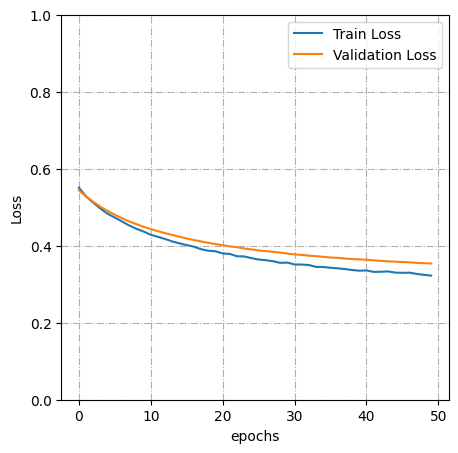

In [19]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5), dpi=100)

axs.grid(linestyle='dashdot')
axs.plot(history.history['loss'])
axs.plot(history.history['val_loss'])
axs.set_xlabel('epochs', fontsize=10)
axs.set_ylabel('Loss', fontsize=10)
axs.legend(['Train Loss', 'Validation Loss'], fontsize=10)
axs.set_ylim(0, 1)
print(f'Loss: Train Loss = {history.history["loss"][-1]:.4f}, Validation Loss = {history.history["val_loss"][-1]:.4f}')

Accuracy: Train Accuracy = 0.8631, Validation Accuracy = 0.8535


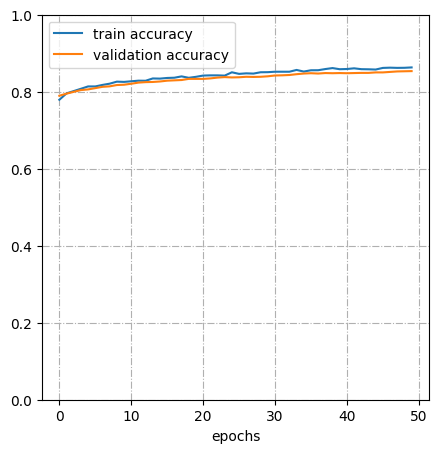

In [20]:
fig, axs = plt.subplots(1,1, figsize = (5, 5), dpi = 100)
axs.grid(linestyle = 'dashdot')
axs.plot(history.history['accuracy'])
axs.plot(history.history['val_accuracy'])
axs.set_xlabel('epochs', fontsize = 10)
axs.legend(['train accuracy', 'validation accuracy'], fontsize = 10)
axs.set_ylim(0, 1)
print(f'Accuracy: Train Accuracy = {history.history["accuracy"][-1]:.4f}, Validation Accuracy = {history.history["val_accuracy"][-1]:.4f}')

In [21]:
# Predictions and scores
test_pred = model.predict(test_dataset)
test_pred = np.argmax(test_pred, axis = 1)

mse = mean_squared_error(test_data['label'], test_pred)
f1 = f1_score(test_data['label'], test_pred, average = 'weighted')
acc = accuracy_score(test_data['label'], test_pred)

print('Mean Squared Error : {0:.5f}'.format(mse))
print('Weighted F1 Score : {0:.3f}'.format(f1))
print('Accuracy Score : {0:.3f} %'.format(acc*100))

63/63 [==============================] - 121s 2s/step
Mean Squared Error : 0.14150
Weighted F1 Score : 0.858
Accuracy Score : 85.850 %


In [22]:
clf = classification_report(test_data['label'], test_pred, target_names = list(classes.values()))
print(clf)

              precision    recall  f1-score   support

      Benign       0.87      0.84      0.86      1000
   Malignant       0.85      0.87      0.86      1000

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000



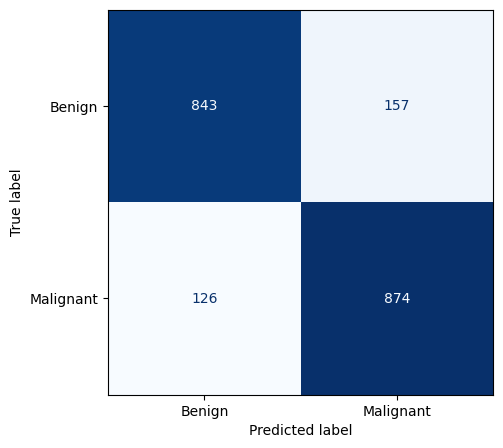

In [23]:
cm = confusion_matrix(test_data['label'], test_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels = list(classes.values()))

fig, ax = plt.subplots(figsize=(5,5))
cmd.plot(ax=ax,  cmap = 'Blues', colorbar = False)

In [24]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_dataset)

# Print test results
print("\nTest Results:")
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

63/63 [==============================] - 122s 2s/step - loss: 0.3505 - accuracy: 0.8585

Test Results:
Test Loss: 0.3504983186721802
Test Accuracy: 0.8585000038146973


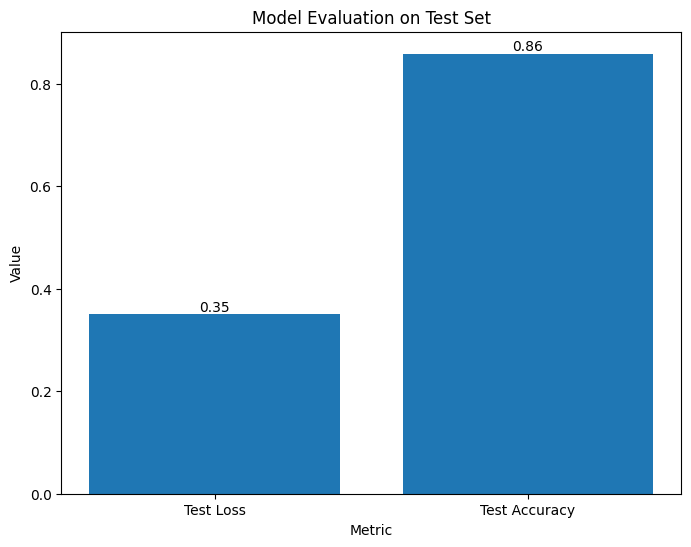

In [25]:
import matplotlib.pyplot as plt

# Create a bar chart
x = ['Test Loss', 'Test Accuracy']
y = [test_loss, test_acc]

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x, y)

# Add labels and title
ax.set_xlabel('Metric')
ax.set_ylabel('Value')
ax.set_title('Model Evaluation on Test Set')

# Add value labels to the bars
for i, v in enumerate(y):
    ax.text(i, v, f"{v:.2f}", ha='center', va='bottom', fontsize=10)

plt.show()

In [26]:
# y_true = test_data['label']
# y_pred = model.predict(test_dataset, verbose=0)[:, 1]

# fpr, tpr, thresholds = roc_curve(y_true, y_pred)
# roc_auc = auc(fpr, tpr)

# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC)')
# plt.legend(loc="lower right")
# plt.show()

In [27]:
test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)

# A function that creating 5 random images in the test set and predictions

# Red title -> a false prediction
# Green title -> a true prediction

def random_test_sample_with_prediction(SEED):
    
    idxs = np.random.default_rng(seed=SEED).permutation(len(test_pred))[:5]
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs - batch_idx * BATCH_SIZE
    idx = idxs

    fig, axs = plt.subplots(1, 5, figsize=(12, 12), dpi=150)

    for i in range(5):
        img = test_take1_[batch_idx[i]][0][image_idx[i]]
        label = test_take1_[batch_idx[i]][1][image_idx[i]].numpy()
        pred_label = int(test_pred[idx[i]])
        pred_prob = model.predict(tf.expand_dims(img, axis=0))[0][pred_label]

        if pred_label == label:
            axs[i].imshow(img, cmap='gray') 
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i]) + ')' + '\nTRUE: ' + classes[label] + '\nPRED: ' + classes[pred_label] + f' ({pred_prob:.2%})', fontsize=8, color='green')
        else:
            axs[i].imshow(img, cmap='gray')
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i]) + ')' + '\nTRUE: ' + classes[label] + '\nPRED: ' + classes[pred_label] + f' ({pred_prob:.2%})', fontsize=8, color='red')

1/1 [==============================] - 0s 181ms/step


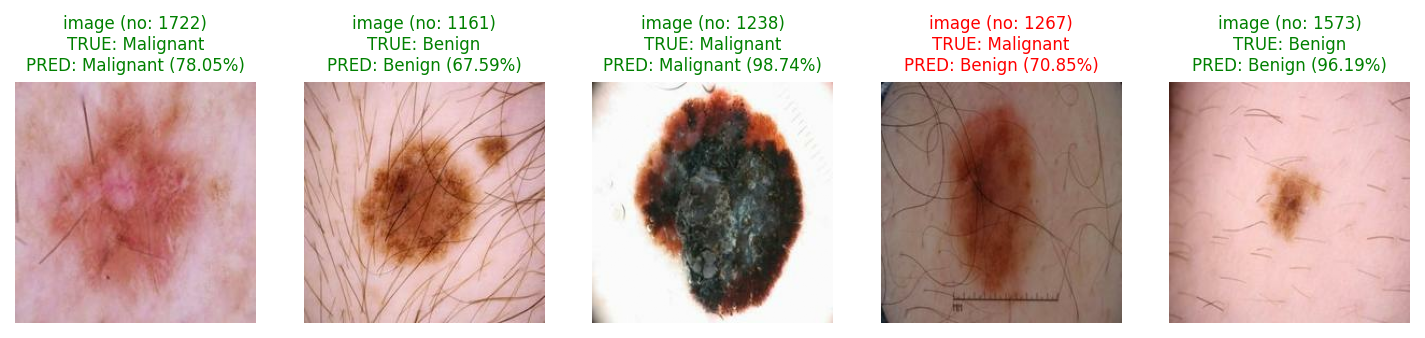

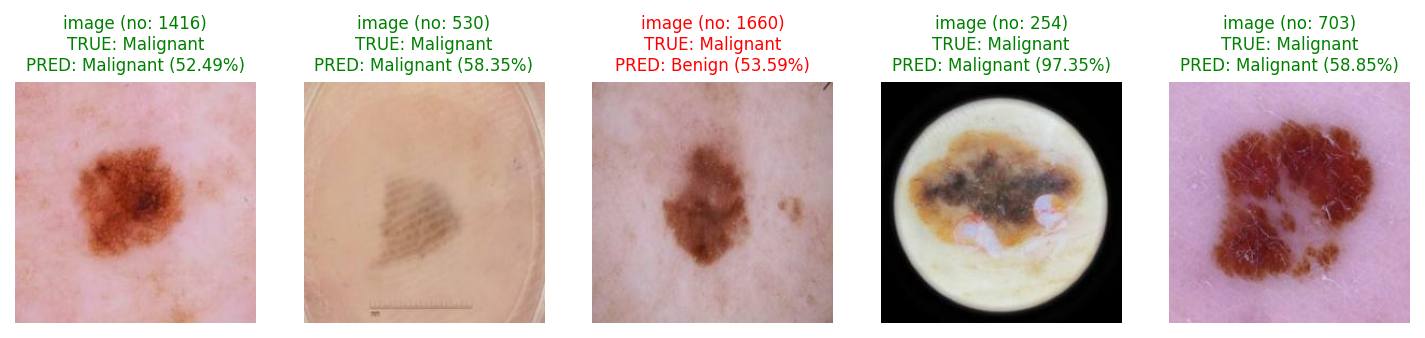

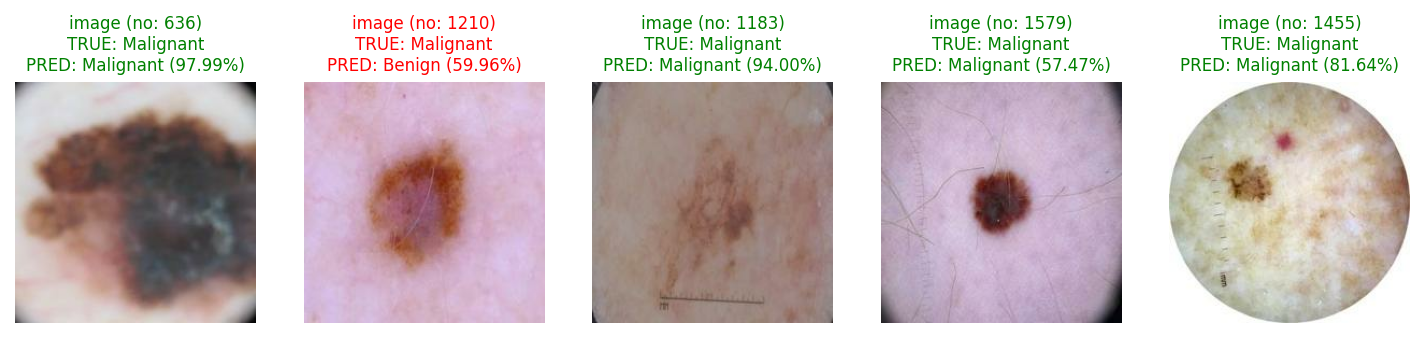

In [28]:
# Red title -> a false prediction
# Green title -> a true prediction

random_test_sample_with_prediction(11)
random_test_sample_with_prediction(104)
random_test_sample_with_prediction(193)

In [29]:
import tensorflow as tf

# Load the saved model
loaded_model = tf.keras.models.load_model('/kaggle/working/my_model.tf')

1/1 [==============================] - 8s 8s/step


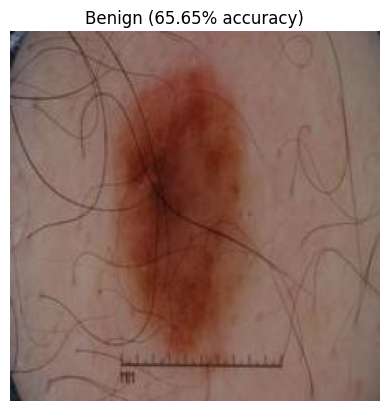

In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# 5742
test_image_path = '/kaggle/input/melanoma-cancer-dataset/test/Malignant/5742.jpg'

test_image = cv2.imread(test_image_path)
test_image = cv2.resize(test_image, (224, 224))
test_image_display = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
test_image_normalized = test_image / 255.0
test_image_normalized = np.expand_dims(test_image_normalized, axis=0)

predictions = loaded_model.predict(test_image_normalized)
predicted_class_index = np.argmax(predictions)
if predicted_class_index == 0:
    predicted_class = 'Benign'
else:
    predicted_class = 'Malignant'

predicted_accuracy = np.max(predictions) *100

# if predicted_class_index == 1:
#     bounding_box = [50, 70, 150, 120]
#     cv2.rectangle(test_image_display, (bounding_box[0], bounding_box[1]), (bounding_box[2], bounding_box[3]), (0, 255, 0), 2)

plt.imshow(test_image_display)
plt.title(f"{predicted_class} ({predicted_accuracy:.2f}% accuracy)")
plt.axis('off')
plt.show()